In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mne # See docs: https://mne.tools/dev/generated/mne.io.read_raw_edf.html
import pyedflib # See docs: https://pyedflib.readthedocs.io/en/latest/
from pyedflib import highlevel

In [4]:
# Defining the file path as a string for easier use
file_path = '/Users/jacksonpowell/Documents/GitHub/learningML/data_files/sub-01_ses-01_task-musicTherapy_eeg.edf'; 

In [5]:
# "highlevel" takes data from .edf file (see docs in includes) and saves in signals (np.array of numbers) and headers (dicts)
signals, signal_headers, data_header = highlevel.read_edf(file_path); 

# Printing to see data and size
print(signal_headers[0]);  
print(signals[0].shape); 

{'label': 'Fp1', 'dimension': 'uV', 'sample_rate': 1024.0, 'sample_frequency': 1024.0, 'physical_max': 31790000.0, 'physical_min': -3184000.0, 'digital_max': 32767, 'digital_min': -32767, 'prefilter': 'HP:0.0Hz LP:512.0Hz N:NoneHz', 'transducer': ''}
(1378304,)


In [6]:
def plot_signal(signal, header, window, color = None, tag = None):

    if not tag: 
        tag = ""; 

    frequency = header["sample_frequency"]; # Takes frequency value from header dict

    total_time_seconds = len(signal) / frequency; # Storing total time in seconds
    total_time_mins = len(signal) / frequency / 60; # Storing total time in minutes 
    time = np.linspace(0, total_time_seconds, len(signals[0]), endpoint=True); # Creating x-axis based on frequency

    start_time = window[0]; # Taking first value in window array, aka the start of the zoomed frame
    stop_time = window[1]; # Taking second value in window array, aka the end of the zoomed frame

    time_frame = stop_time - start_time; # Total time of zoomed frame
    zoomed_frame = int(time_frame * frequency); # Number of data points in zoomed frame
    zoomed_signal = signal[int(start_time * frequency) : int(stop_time * frequency)]; # Subset of signal plotted
    zoomed_time = np.linspace(start_time, stop_time, zoomed_frame, endpoint=True); # x-axis for zoomed plot

    # Plot specificiations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4)); 

    ax1.plot(time, signal, color = color, linewidth = 0.3); 
    ax1.set_xlabel('time (s)'); 
    ax1.set_ylabel('voltage (uV)'); 
    ax1.set_title(f"total frame, {tag} {header['label']}"); 

    ax2.plot(zoomed_time, zoomed_signal, color = color, linewidth = 0.3); 
    ax2.set_xlabel('time (s)'); 
    ax2.set_ylabel('voltage (uV)'); 
    ax2.set_title(f"from {start_time}s to {stop_time}s, {tag} {header['label']}"); 

    plt.show(); 

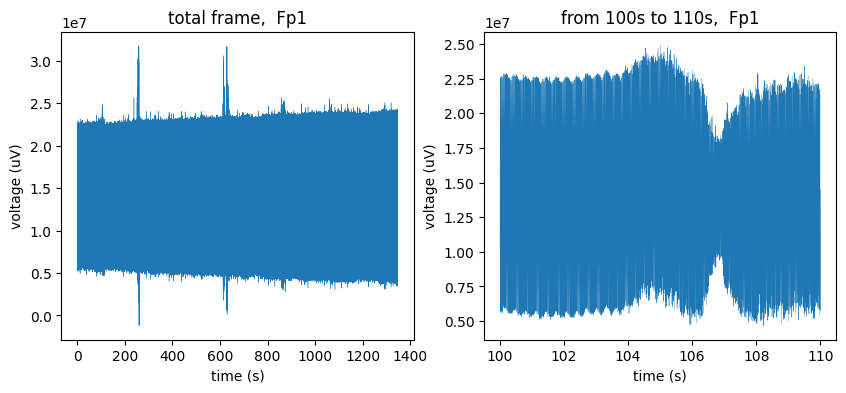

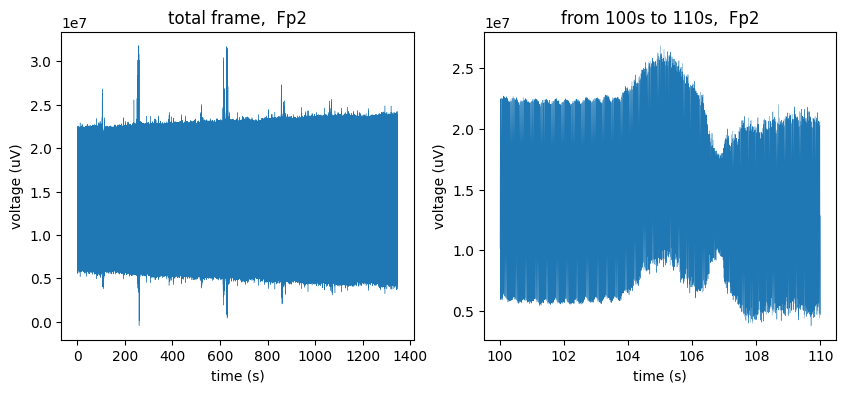

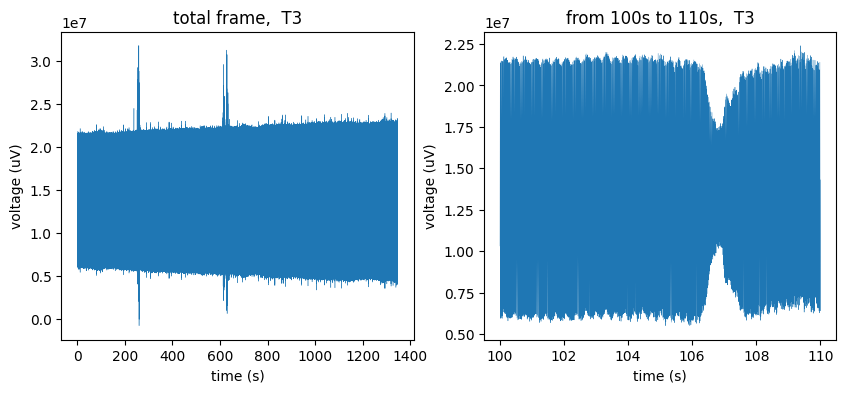

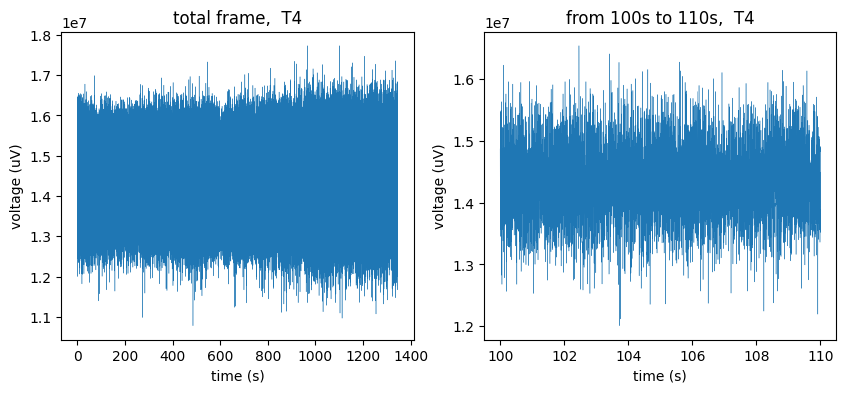

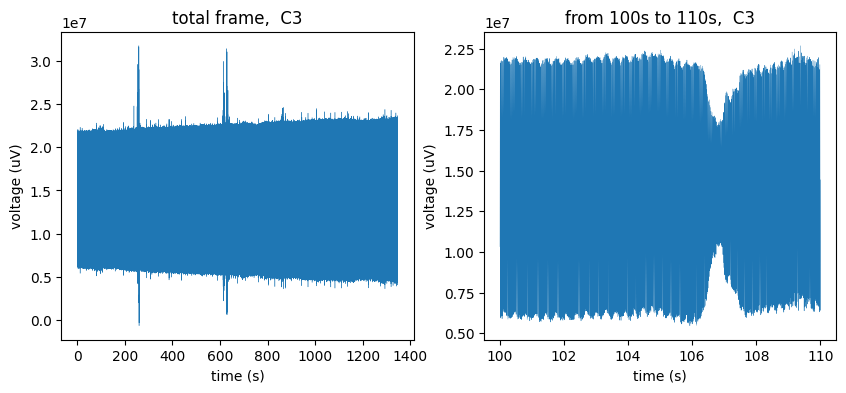

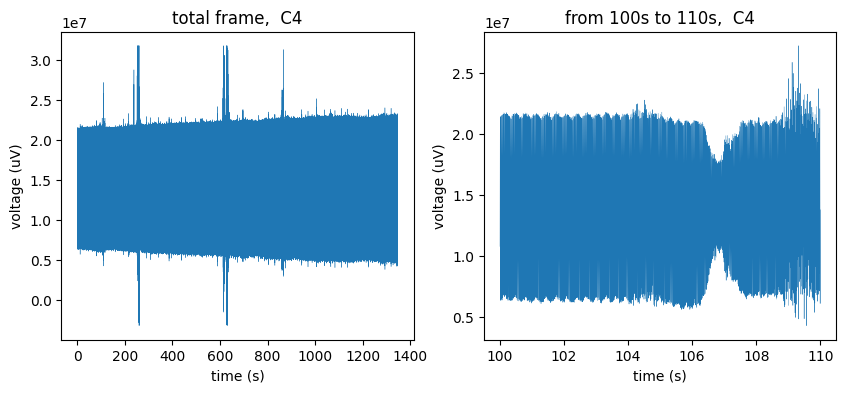

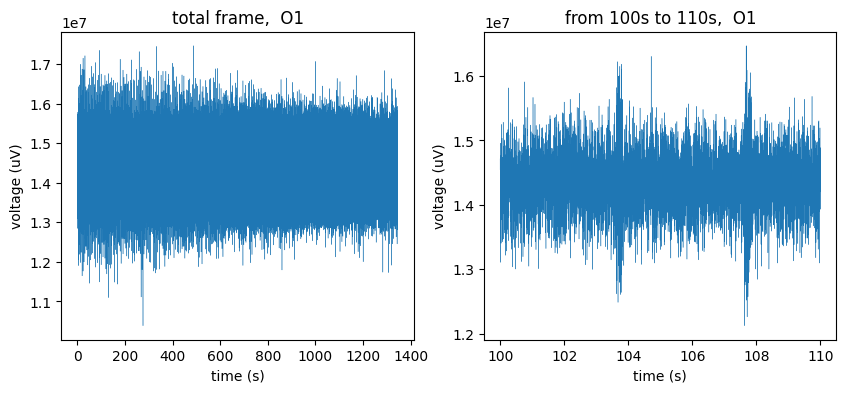

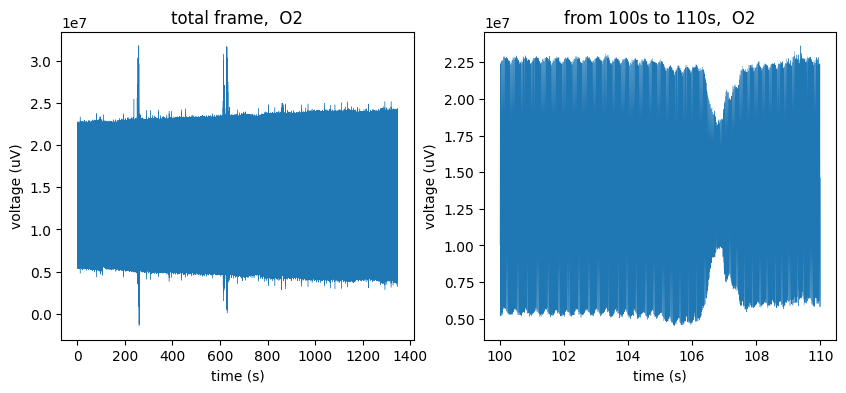

In [7]:
start_time = 100; 
stop_time = 110; 

for i in range(0, len(signal_headers), 1): # Plotting over all electrodes
    # Information is the signal to be plotted, its corresponding header, and then a zoomed in window
    # I.e., if you want to see a zoomed in plot from seconds 0 to 5, the third argument would be [0,5]
    plot_signal(signals[i], signal_headers[i], [start_time, stop_time]); 

In [8]:
def plot_all_signal(all_signals, all_headers, tag = None): 

    figure_length = len(all_signals); # In inches (scaling based on # of electrodes)
    plt.figure(figsize = (figure_length, 7)); 

    for i in range(0, len(all_signals), 1): # Plotting over all electrodes
        # Information is the signal to be plotted, its corresponding header, and then a zoomed in window
        # I.e., if you want to see a zoomed in plot from seconds 0 to 5, the third argument would be [0,5] 

        if not tag: 
            tag = ""; 

        frequency = all_headers[i]["sample_frequency"]; # Takes frequency value from header dict

        total_time_seconds = len(all_signals[i]) / frequency; # Storing total time in seconds
        total_time_mins = len(all_signals[i]) / frequency / 60; # Storing total time in minutes 
        time = np.linspace(0, total_time_seconds, len(signals[0]), endpoint=True); # Creating x-axis based on frequency

        # Plot specificiations
        len(all_signals)

        plt.tight_layout(h_pad = 2)
        ax = plt.subplot(4, 2, i + 1)
        
        ax.plot(time, all_signals[i], linewidth = 0.3); 
        ax.set_xlabel('time (s)', fontsize = 8); 
        ax.set_ylabel('voltage (uV)', fontsize = 8); 
        ax.set_title(f"{tag} {all_headers[i]['label']}", fontsize = 10); 
        plt.xticks(fontsize=8); 
        plt.yticks(fontsize=8); 

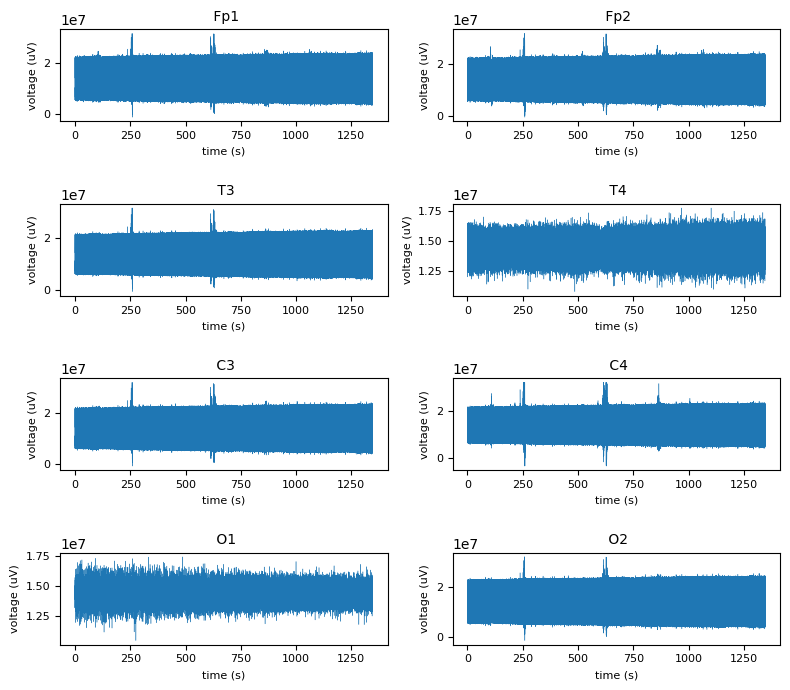

In [17]:
plot_all_signal(signals, signal_headers)

In [10]:
from scipy import signal

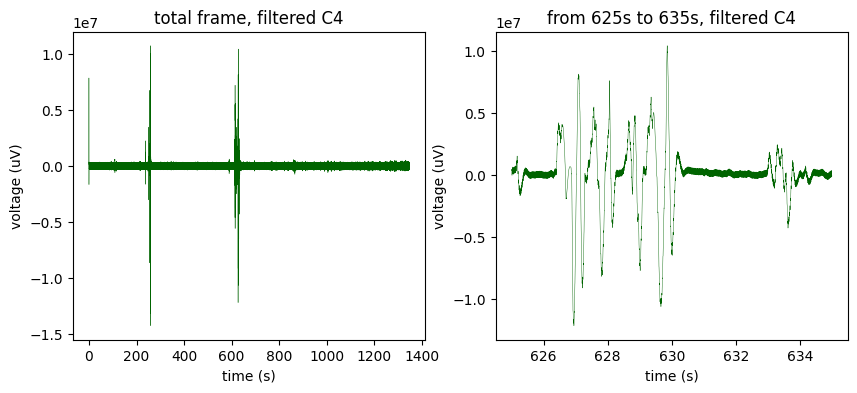

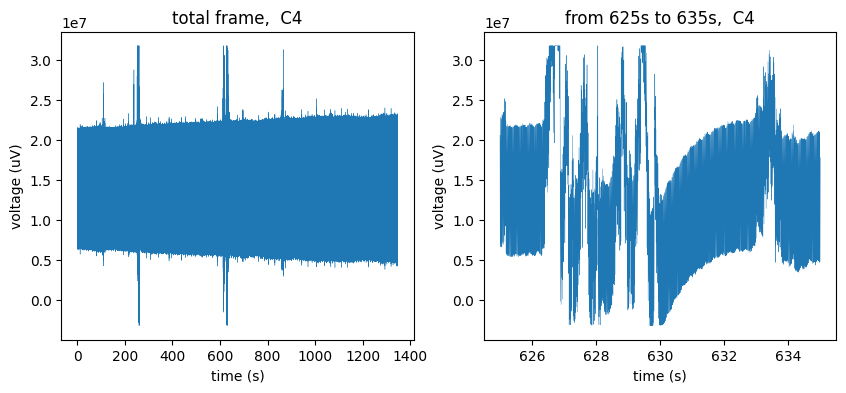

In [11]:
signal_num = 5; # Which signal we want to filter

# A zoomed in timeframe, if we want to look closely at a segment of the wave form
start_time = 625; 
stop_time = 635; 

# Docs: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html
# Bandpass filter with delta F freq values contained in [f1,f2]---functions as corner frequencies, like in electronics
bandpass = signal.butter(1, [2, 5], 'bandpass', fs=1024, output='sos'); 
filtered_signal = signal.sosfilt(bandpass, signals[signal_num]); 

# Plotting to compare filtered and unfiltered data
plot_signal(filtered_signal, signal_headers[signal_num], [start_time, stop_time], 'darkgreen', tag = "filtered"); 
plot_signal(signals[signal_num], signal_headers[signal_num], [start_time, stop_time]); 

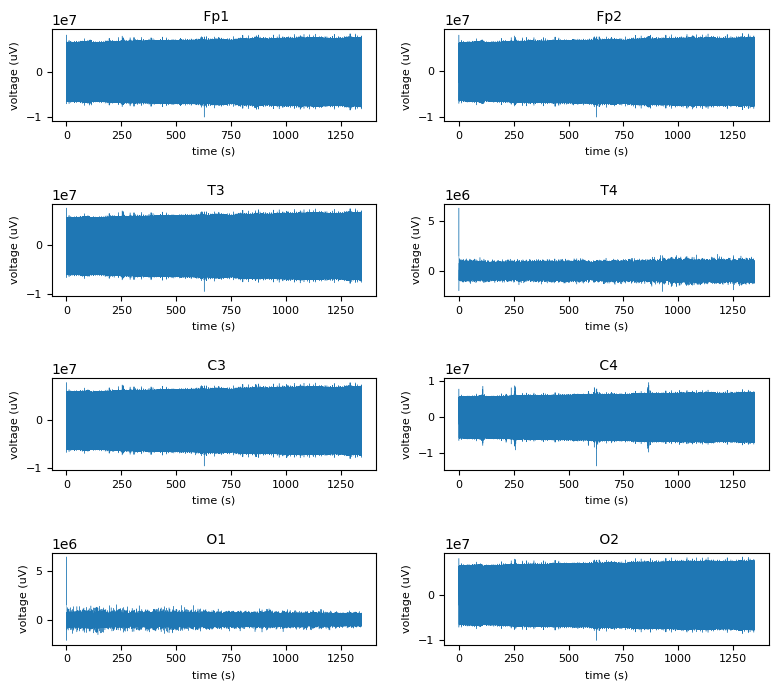

In [20]:
filtered_signals = np.zeros((len(signals), len(signals[0]))); 

bandpass = signal.butter(1, [2, 5], 'bandpass', fs=1024, output='sos'); 

for i in range(0, len(signals), 1):
    filtered_signals[i] = signal.sosfilt(bandpass, signals[i]); 

# Plotting to compare filtered and unfiltered data
plot_all_signal(filtered_signals, signal_headers)

In [13]:
from scipy.fft import fft, ifft, fftfreq
from scipy.stats import skew, kurtosis

In [14]:
# Docs: https://scikit-learn.org/stable/modules/feature_extraction.html
from sklearn.feature_extraction import DictVectorizer

In [15]:
# Features to add that are pre-built: 
    #   Docs: https://docs.scipy.org/doc/scipy/reference/stats.html
    #   Entropy, differential entropy
    #   Trimmed statistics
    #   Median absolute deviation
    #   Cumulative and relative frequency

# Features to add by user: 
    #   Spikes, polyspikes---value and number
    #   Spike and wave
    #   Sharp wave complexes
    #   Slow cortical potentials
    #   Sensorimotor rhythms
    #   P300 event-related potential
    #   Steady-state visual evoked potentials
    #   Error-related negative evoked potentials

def extractFeatures(all_signals, all_headers):

    figure_length = len(all_signals); # In inches (scaling based on # of electrodes)
    plt.figure(figsize = (figure_length, 7)); 

    features_matrix = np.zeros((len(signals), 6)) # Initializing 2D, x by 1 array
    vec = DictVectorizer(); 

    # The list of features, in a dictionary, that we will extract
    for i in range(0, len(all_signals), 1):

        local_features_dict = {'label' : all_headers[i]['label'], 
                    'mean' : 0, 
                    'std_dev': 0,
                    'skewness' : 0,
                    'kurt' : 0, 
                    'dominant_freq' : 0}

        # Populating the features dictionary 
        local_features_dict['mean'] = np.mean(all_signals[i]); 

        std_dev = np.std(all_signals[i]); 
        local_features_dict['std_dev'] = std_dev; 

        local_features_dict['skewness'] = skew(all_signals[i]); 
        local_features_dict['kurt'] = kurtosis(all_signals[i]); 

        # Normalizing the signal before fft processing
        normalized_signal = (all_signals[i] - np.mean(all_signals[i])) / np.std(all_signals[i])

        # The total number and time between data points
        N = len(all_signals[i]); 
        delta_t = 1 / all_headers[i]['sample_frequency']; 


        # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        # User defined features  
        # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

        j = 0; 
        num_spikes = 0; 
        while j < len(all_signals[i]):
            if all_signals[i][j] > 3 * std_dev:
                start_pos = j; 
                while all_signals[i][j] > 3 * std_dev and not j == len(all_signals[i]) - 1:
                    j += 1; 
                stop_pos = j; 
        
                duration = (stop_pos - start_pos) * delta_t; 
                if duration > 0.05: # 50 ms currently 
                    # print(f"{all_headers[i]['label']} had spike at {start_pos / all_headers[i]['sample_frequency']} to {stop_pos / all_headers[i]['sample_frequency']} with duration = {duration}"); 
                    num_spikes += 1; 
            j += 1; 
        
        print(f"{all_headers[i]['label']} had {num_spikes}"); 

        # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        # FFT  
        # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

        # Running fft and solving for the frequency domain (x axis)
        fft_values = fft(normalized_signal); 
        freq_domain = np.fft.fftfreq(N, d = delta_t); 
        fft_magnitude = np.abs(fft_values); 
        
        # Dominant frequency found as the highest magnitude fft value and its corresponding location in the frequency domain
        local_features_dict['dominant_freq'] = freq_domain[np.argmax(fft_magnitude)]; 
        
        features_vec = vec.fit_transform(local_features_dict).toarray(); 
        vec.get_feature_names_out()

        features_matrix[i] = features_vec; 


        # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        # Plotting 
        # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

        plt.tight_layout(h_pad = 2)
        ax = plt.subplot(4, 2, i + 1)
        
        # I don't really understand what // does but every online resource uses this 
        ax.plot(freq_domain[:N//2], abs(fft_values[0:N//2])); 
        ax.set_xlabel('freq (hz)', fontsize = 8); 
        ax.set_title(f"{local_features_dict['label']}, dom_freq = {round(local_features_dict['dominant_freq'], 2)} hz", fontsize = 10); 
        plt.xticks(fontsize = 8); 
        plt.yticks(fontsize = 8); 

    return features_matrix; 

Fp1 had 4
Fp2 had 5
T3 had 7
T4 had 1
C3 had 7
C4 had 15
O1 had 1
O2 had 3


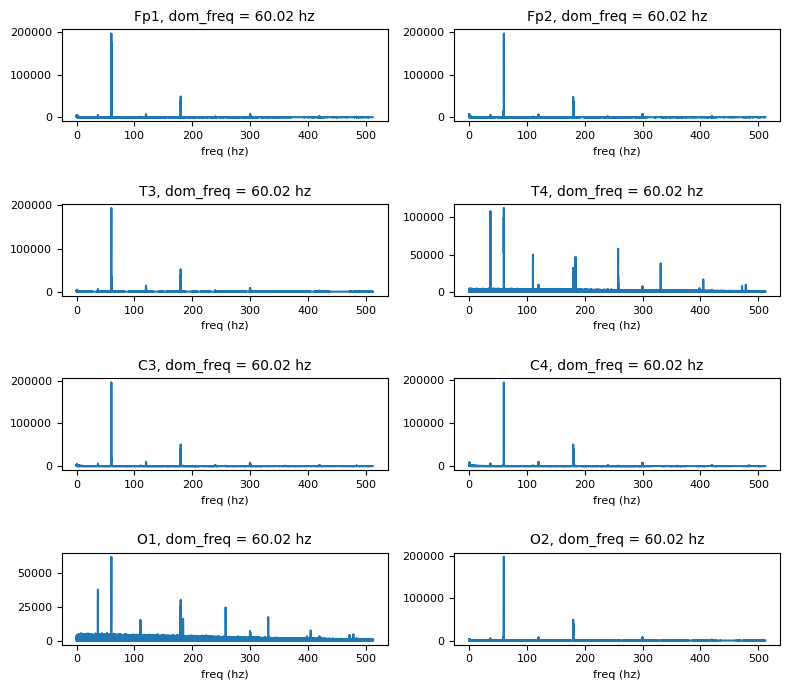

In [16]:
# Build features matrix

features = extractFeatures(signals, signal_headers); 
